In [1]:
import pandas as pd
import numpy as np
import timm
import torchvision.transforms as T
import torch

from wildlife_tools.features import SuperPointExtractor, SiftExtractor, DiskExtractor, AlikedExtractor, DeepFeatures
from wildlife_tools.data import ImageDataset

metadata = {'metadata':  pd.read_csv('../tests/TestDataset/metadata.csv'), 'root': '../tests/TestDataset'}
transform = T.Compose([T.Resize([224, 224]), T.ToTensor()])
dataset = ImageDataset(**metadata, transform=transform)


/Users/ash/phd/guppies/coding/wildlife-tools/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('../tests/TestDataset/metadata.csv')
df.head()

,image_id,identity,path,split
0,image_1,a,images/identity_a/image_1.JPG,train
1,image_2,a,images/identity_a/image_2.JPG,test
2,image_3,b,images/identity_b/image_3.JPG,train
3,image_4,b,images/identity_b/image_4.JPG,test


# Extract local features

In [ ]:
extractor = SiftExtractor()
output = extractor(dataset)

assert len(output) == len(dataset)
assert tuple(output.features[0]['keypoints'].shape) == (256, 2)
assert tuple(output.features[0]['descriptors'].shape) == (256, 128)

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.22s/it]


In [ ]:
# print(output.features[1]['keypoints'])
print(output.features[1]['descriptors'])

tensor([[0.0857, 0.0693, 0.0675,  ..., 0.0276, 0.0225, 0.0811],
        [0.0904, 0.0943, 0.0219,  ..., 0.0694, 0.0310, 0.0694],
        [0.0883, 0.0581, 0.0395,  ..., 0.0395, 0.0939, 0.0789],
        ...,
        [0.0884, 0.0884, 0.0884,  ..., 0.0884, 0.0884, 0.0884],
        [0.0884, 0.0884, 0.0884,  ..., 0.0884, 0.0884, 0.0884],
        [0.0884, 0.0884, 0.0884,  ..., 0.0884, 0.0884, 0.0884]])


In [ ]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Extract embeddings from the output
embeddings = output.features

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the reduced embeddings
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
extractor = SuperPointExtractor()
output = extractor(dataset)

assert len(output) == len(dataset)
assert tuple(output.features[0]['keypoints'].shape) == (256, 2)
assert tuple(output.features[0]['descriptors'].shape) == (256, 256)

Downloading: "https://github.com/magicleap/SuperGluePretrainedNetwork/raw/master/models/weights/superpoint_v1.pth" to /Users/ash/.cache/torch/hub/checkpoints/superpoint_v1.pth


100%|██████████| 4.96M/4.96M [00:00<00:00, 36.1MB/s]
100%|█████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.24s/it]


In [ ]:
extractor = AlikedExtractor()
output = extractor(dataset)

assert len(output) == len(dataset)
assert tuple(output.features[0]['keypoints'].shape) == (256, 2)
assert tuple(output.features[0]['descriptors'].shape) == (256, 128)

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  9.59it/s]


In [ ]:
extractor = DiskExtractor()
output = extractor(dataset)

assert len(output) == len(dataset)
assert tuple(output.features[0]['keypoints'].shape) == (256, 2)
assert tuple(output.features[0]['descriptors'].shape) == (256, 128)

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.90it/s]


# Extract deep features

In [2]:
backbone = timm.create_model('hf-hub:BVRA/MegaDescriptor-T-224', num_classes=0, pretrained=True)
extractor = DeepFeatures(backbone)
output = extractor(dataset)

assert len(output) == len(dataset)
assert tuple(output.features.shape) == (len(dataset), 768)

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.19s/it]


In [3]:
# Convert embeddings to NumPy array
embeddings = output.features
if isinstance(embeddings, torch.Tensor):
    embeddings = embeddings.detach().cpu().numpy()

# Extract labels
labels = output.labels_string  # Assuming labels are stored here

In [4]:
print(labels)
print(embeddings.shape)

['a' 'a' 'b' 'b']
(4, 768)


In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)


In [6]:
from collections import defaultdict

# Initialize dictionaries to hold similarities
same_identity_sims = defaultdict(list)
different_identity_sims = defaultdict(list)

num_embeddings = len(embeddings)

for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        sim = similarity_matrix[i][j]
        if labels[i] == labels[j]:
            same_identity_sims[labels[i]].append(sim)
        else:
            key = f"{labels[i]} vs {labels[j]}"
            different_identity_sims[key].append(sim)

# Compute average similarities
avg_same_identity_sim = np.mean([np.mean(sims) for sims in same_identity_sims.values()])
avg_different_identity_sim = np.mean([np.mean(sims) for sims in different_identity_sims.values()])

print(f"Average similarity within the same identity: {avg_same_identity_sim:.4f}")
print(f"Average similarity between different identities: {avg_different_identity_sim:.4f}")


Average similarity within the same identity: 0.5767
Average similarity between different identities: 0.0419


In [12]:
print(same_identity_sims)
print(different_identity_sims)

defaultdict(<class 'list'>, {'a': [np.float32(0.7651534)], 'b': [np.float32(0.38824427)]})
defaultdict(<class 'list'>, {'a vs b': [np.float32(0.109083086), np.float32(-0.010203343), np.float32(0.01099782), np.float32(0.05778585)]})


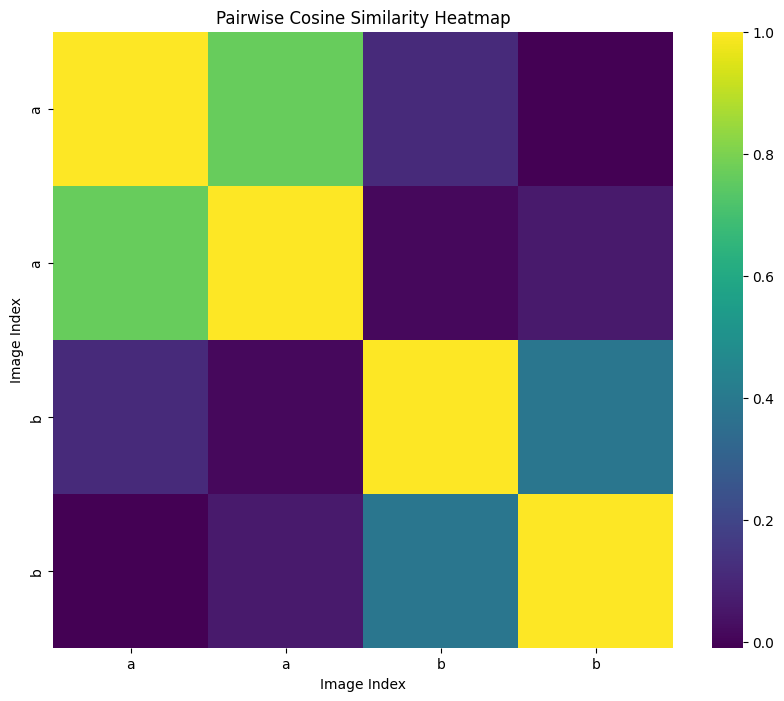

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=labels, yticklabels=labels, cmap='viridis')
plt.title('Pairwise Cosine Similarity Heatmap')
plt.xlabel('Image Index')
plt.ylabel('Image Index')
plt.show()


In [8]:
from sklearn.manifold import TSNE

# Determine the number of samples
n_samples = embeddings.shape[0]

# Set perplexity to a value less than n_samples
perplexity_value = min(5, n_samples - 1)

# Initialize and fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(embeddings)


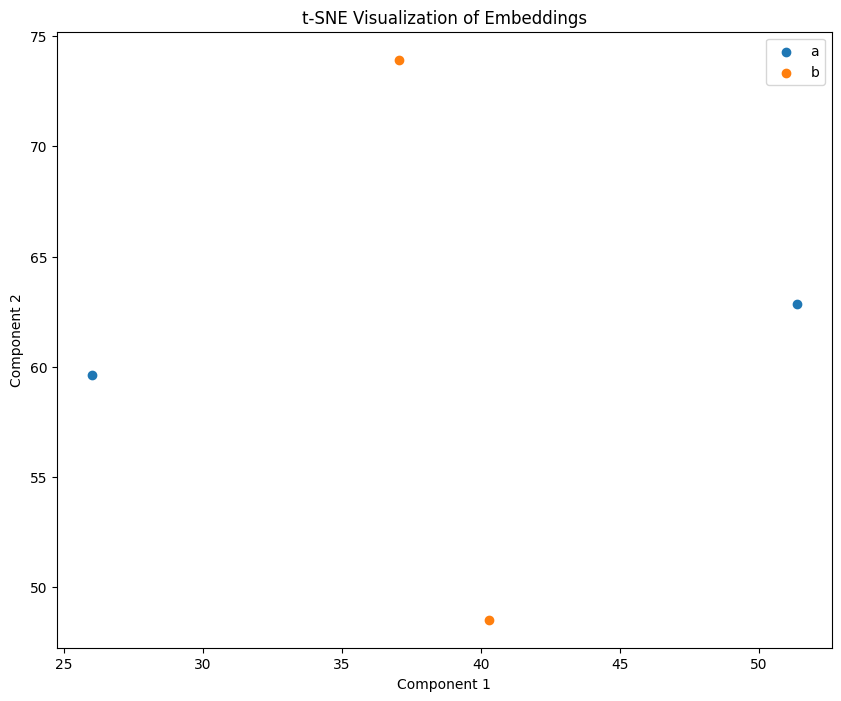

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=label)

plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [10]:
from scipy.spatial.distance import cdist

# Calculate pairwise distances
distances = cdist(embeddings, embeddings, metric='euclidean')

print(distances)

[[ 0.         15.05763108 35.27242825 32.63103204]
 [15.05763108  0.         37.58558547 32.12597857]
 [35.27242825 37.58558547  0.         30.71924729]
 [32.63103204 32.12597857 30.71924729  0.        ]]


In [11]:
from sklearn.preprocessing import MinMaxScaler

# Normalize distances using Min-Max scaling
scaler = MinMaxScaler()
normalized_distances = scaler.fit_transform(distances)

print(normalized_distances)
# can see that identity a images are close, b are kinda far. but a and b are far from one another!

[[0.         0.4006225  0.93845627 1.        ]
 [0.42689522 0.         1.         0.9845223 ]
 [1.         1.         0.         0.94141207]
 [0.92511442 0.854742   0.81731459 0.        ]]


In [13]:
avg_same = np.mean([normalized_distances[i][j] for i in range(len(labels)) for j in range(len(labels)) if labels[i] == labels[j]])
avg_diff = np.mean([normalized_distances[i][j] for i in range(len(labels)) for j in range(len(labels)) if labels[i] != labels[j]])
print(f"Average normalized distance within the same identity: {avg_same:.4f}")
print(f"Average normalized distance between different identities: {avg_diff:.4f}")

Average normalized distance within the same identity: 0.3233
Average normalized distance between different identities: 0.9629
